In [2]:
import xarray as xr
import numpy as np
import os

import scipy as sp
import sys
import pandas as pd
import datetime


In [3]:
region="EQ"
latN=15
latS=-15
lonW=60
lonE=150

In [ ]:
wave = "er"
var = "vr_total_source"
mode= "wet"
ens = "ensmean"

folder_model = f"/g/data/v46/fm6730/dataout/lifecycle/vorticity_budget/{wave}/{mode}/"
file_model = f"hovmuller_lon133_{mode}_{wave}_NDJFMA_vorticity_budget_{ens}.nc"
ds_model = xr.open_dataset(folder_model+file_model)
ds_model = ds_model.sel(lat=slice(latN,latS), lon=slice(lonW,lonE))

FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/v46/fm6730/dataout/lifecycle/vorticity_budget/er/wet/hovmuller_lon133_wet_er_NDJFMA_vorticity_budget.nc'

In [4]:
print(ds_model, ds_diag)

<xarray.Dataset>
Dimensions:            (time: 381, lat: 13, lon: 37, time_lag: 3)
Coordinates:
  * time               (time) datetime64[ns] 1981-02-01 ... 1982-02-16
  * lat                (lat) float32 15.0 12.5 10.0 7.5 ... -10.0 -12.5 -15.0
  * lon                (lon) float32 60.0 62.5 65.0 67.5 ... 145.0 147.5 150.0
  * time_lag           (time_lag) int32 -2 -1 0
Data variables:
    vrD                (time, lat, lon, time_lag) float32 ...
    fD                 (time, lat, lon, time_lag) float32 ...
    residual           (time, lat, lon, time_lag) float32 ...
    adv_vr_vertical    (time, lat, lon, time_lag) float32 ...
    adv_vr_zonal       (time, lat, lon, time_lag) float32 ...
    adv_vr_meridional  (time, lat, lon, time_lag) float32 ...
    vr_total_source    (time, lat, lon, time_lag) float32 ...
    vr_planetary_adv   (time, lat, lon, time_lag) float32 ...
    vr_tilt            (time, lat, lon, time_lag) float32 ...
    vr_stretch         (time, lat, lon, time_lag) floa

In [5]:
rmsa_model_th = np.sqrt((ds_model["dvr_dt"]**2.).mean(dim=['time', 'lon', 'lat']))
rmsa_diag_th = np.sqrt((ds_diag["dvr_dt"]**2.).mean(dim=['time', 'lon', 'lat']))

In [6]:
rmsa_model = np.sqrt((ds_model**2.).mean(dim=['lon', 'lat']))
rmsa_diag = np.sqrt((ds_diag**2.).mean(dim=['lon', 'lat']))

In [7]:
vars = ["vrD", "fD", "residual", "adv_vr_vertical", "adv_vr_zonal", "adv_vr_meridional",
"vr_total_source", "vr_planetary_adv", "vr_tilt", "vr_stretch", "dvr_dt"] 

rmsa_model_normalised = rmsa_model/rmsa_model_th
rmsa_diag_normalised = rmsa_diag/rmsa_diag_th


In [11]:
rmsa_model_normalised

time_sel = rmsa_model_normalised.time


In [13]:
rmsa_diag_normalised['time'] = rmsa_diag_normalised.time.dt.floor('D')

In [15]:
rmsa_diag_test = rmsa_diag_normalised.sel(time=time_sel)

In [16]:
rmsa_diag_test

<xarray.Dataset>
Dimensions:            (time: 381)
Coordinates:
  * time               (time) datetime64[ns] 1981-02-01 ... 1982-02-16
Data variables:
    vrD                (time) float32 0.7879 0.7575 0.7374 ... 0.6292 0.6031
    fD                 (time) float32 1.345 1.296 1.253 ... 1.192 1.125 1.077
    residual           (time) float32 79.9 80.98 81.54 ... 104.1 103.5 101.8
    adv_vr_vertical    (time) float32 75.63 74.59 73.19 ... 85.47 84.81 84.1
    adv_vr_zonal       (time) float32 1.652 1.649 1.674 ... 2.403 2.288 2.167
    adv_vr_meridional  (time) float32 2.005 2.008 2.002 ... 2.52 2.417 2.329
    vr_total_source    (time) float32 1.573 1.543 1.521 ... 1.306 1.279 1.247
    vr_planetary_adv   (time) float32 1.028 1.028 1.025 ... 1.189 1.133 1.072
    vr_tilt            (time) float32 84.82 82.44 80.25 ... 116.3 115.4 113.3
    vr_stretch         (time) float32 1.709 1.652 1.605 ... 1.337 1.245 1.199
    adv_vr             (time) float32 75.83 74.81 73.4 ... 85.43 84.77 84.08
    dvr_dt             (time) float32 0.8355 0.8227 0.808 ... 1.049 1.025 0.9905

In [17]:
# Fit a cosine function to the data
# Code from https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
import numpy, scipy.optimize

def fit_cos(tt, yy):
    '''Fit cos to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def cosfunc(t, A, w, p, c):  return A * numpy.cos(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(cosfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.cos(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [162]:
# tt = np.linspace(0,len(rmsa_model_normalised['dvr_dt'].time),1)
yy = rmsa_diag_normalised['dvr_dt'].isel(time=slice(0,20))
tt = np.linspace(0,0.1,len(yy))

yy2 = rmsa_model_normalised['dvr_dt'].isel(time=slice(0,20),time_lag=0)
tt2 = np.linspace(0,0.1,len(yy2))

In [163]:
cosfit = fit_cos(tt, yy)
cosfit2 = fit_cos(tt2, yy2)

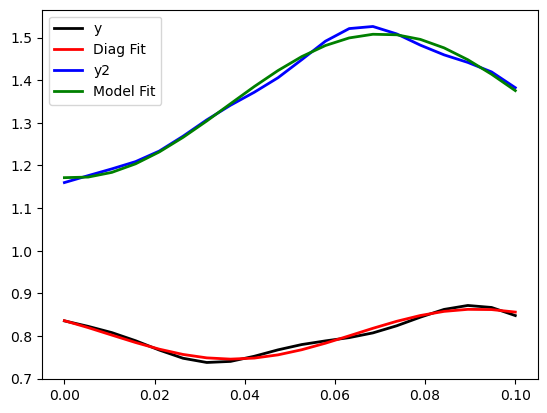

In [165]:
import matplotlib.pyplot as plt
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, cosfit["fitfunc"](tt), "r-", label="Diag Fit", linewidth=2)
plt.plot(tt2, yy2, "-b", label="y2", linewidth=2)
plt.plot(tt2, cosfit2["fitfunc"](tt2), "g-", label="Model Fit", linewidth=2)
plt.legend(loc="best")
plt.show()